# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy

# Importer les données

In [2]:
data = pd.read_csv('./data2.csv', sep=";")

## Mise en forme Série Temporelle

In [3]:
#  Séléectionner les bonnes colonnes
data = data.iloc[:, [0, 1, 6]].to_numpy()

# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

# Afficher la série temporelle

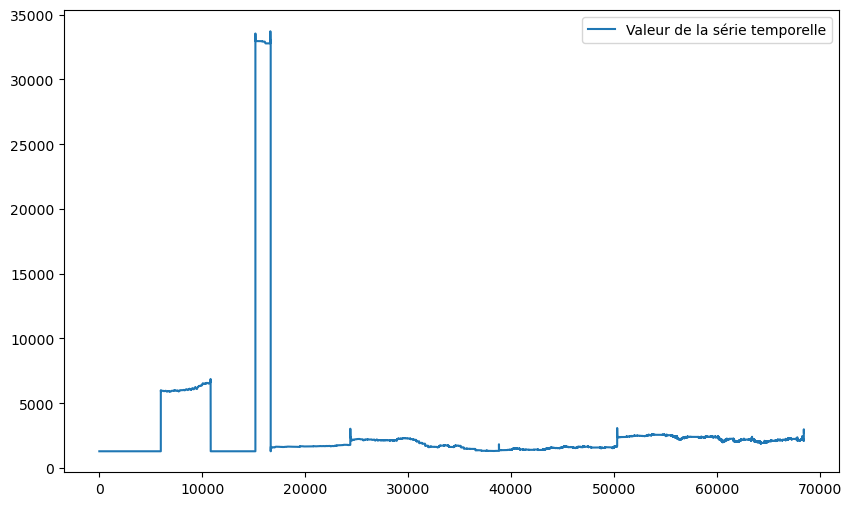

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues.

Sur le début de la plage de données, on observe des paliers de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur d'autres valeurs:

1) entre 0 et 10 000 on a un pic qui passe de 1 280 à environ 6 500
2) entre 15 000 et 20 000 on a un pic qui passe de 1 280 à 32 770

Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

## On enlève le début

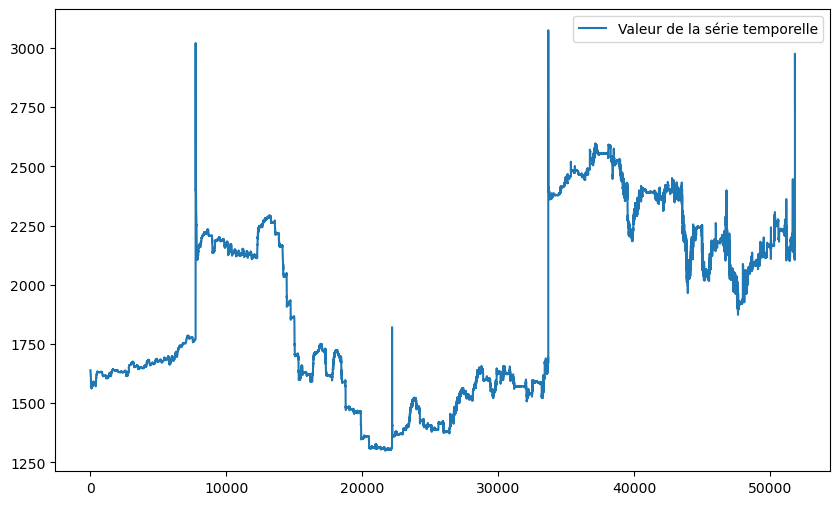

In [5]:
# D'après la base de donnée on obtient cet indice
data_crop = data[16656:, 2] 

# Transformation en série temporelle
time_serie_crop = pd.Series(data_crop, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On remarque qu'il nous reste des pics qui indiqueraient des discontinuités. On va donc commencer par suppriemr ces valeurs aberrantes.

## On enlève les pics

### On detecte où sont les pics 

In [40]:
# Pierre
def detect_pic(arr, seuil=100):
    pic_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(arr) - 1):
        
        # on regarde si la différence entre les 2 valeurs sont plus grandes en valeur absolue que le seuil
        # si oui on considère qu'il y a un pic 
        if arr[i] < arr[i + 1] - seuil or arr[i] > arr[i + 1] + seuil:
            pic_indices.append(i-1) 
            
    return pic_indices

In [6]:
# Ines
def detect_pic(data, seuil=100):
    pic_indices = []
    offset_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(data) - 2):
        
        # on regarde si la différence entre les 2 valeurs est plus grande en valeur absolue que le seuil
        if np.abs(data[i] - data[i+1]) >= seuil :
            # si le saut suivant est aussi supérieur à un pic alors ceci est une valeur aberrante
            if np.abs(data[i+1] - data[i+2]) >= seuil : 
                pic_indices.append(i+1) 
            # sinon on considère qu'il y a un problème d'offset
            else : 
                offset_indices.append(i+1) 
        
    return pic_indices, offset_indices

In [7]:
pic, offset = detect_pic(data_crop)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_crop[pic])

Nombre de pics détectés : 15
Nombre d'offset détectés : 11
Indices des pics : [7733, 7734, 7735, 22178, 33666, 33667, 33668, 51166, 51167, 51168, 51644, 51645, 51646, 51803, 51804]
Indices des offset : [7736, 22179, 33669, 45008, 45982, 46699, 46781, 50274, 51169, 51647, 51805]
Valeurs des pics : [2325 3021 2849 1821 3075 2778 2345 2123 2362 2255 2342 2206 2446 2976
 2221]


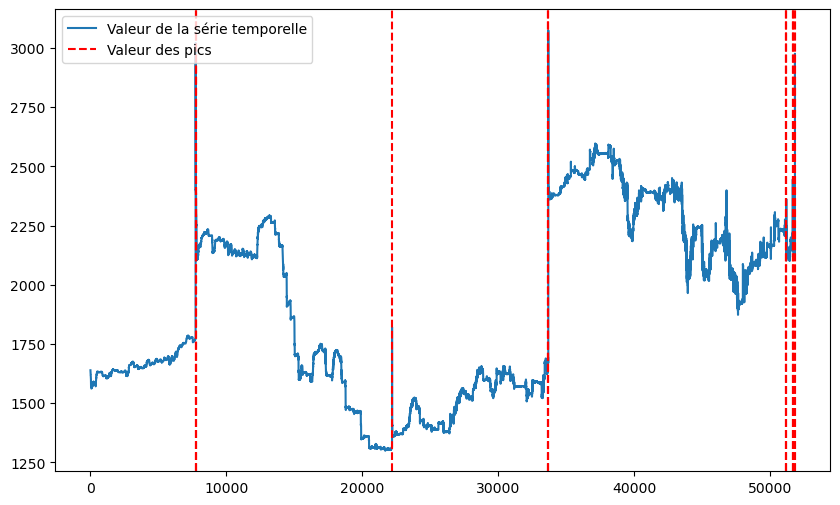

In [8]:
# Affichage des pics sur notre série temporelle pour vérifier si c'est cohérent 

plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')

# Ajout des barres verticales correspondant aux pics
for i,x in enumerate(pic):
    if i == 0:
        plt.axvline(x=x, color='red', linestyle='--', label='Valeur des pics')
    else:
        plt.axvline(x=x, color='red', linestyle='--')

plt.legend(loc='upper left')
plt.show()

In [44]:
# def delete_pic(arr, indices) :
#    data_clean = arr
#    for i in indices:
#        data_clean = [x - arr[i-1] for x in arr[i:]]
#        # print(i,arr[i])
#    return data_clean

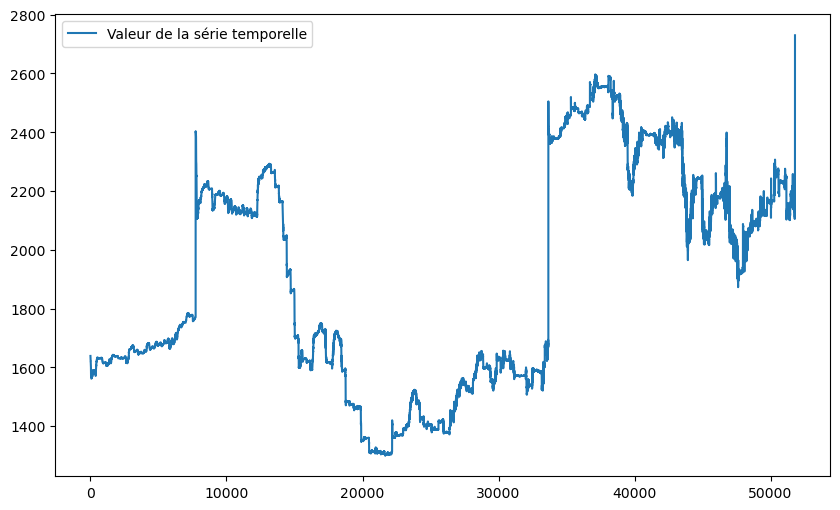

In [9]:
# Suppression des pics
data_clean = np.delete(data_crop, pic)

# Transformation en série temporelle
time_serie_clean = pd.Series(data_clean, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_clean, label='Valeur de la série temporelle')
plt.legend()
plt.show()

In [10]:
# On vérifie qu'on a que des offset maintenant
pic, offset = detect_pic(data_clean)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_clean[pic])

Nombre de pics détectés : 0
Nombre d'offset détectés : 10
Indices des pics : []
Indices des offset : [7733, 22175, 33662, 45001, 45975, 46692, 46774, 50267, 51159, 51790]
Valeurs des pics : []


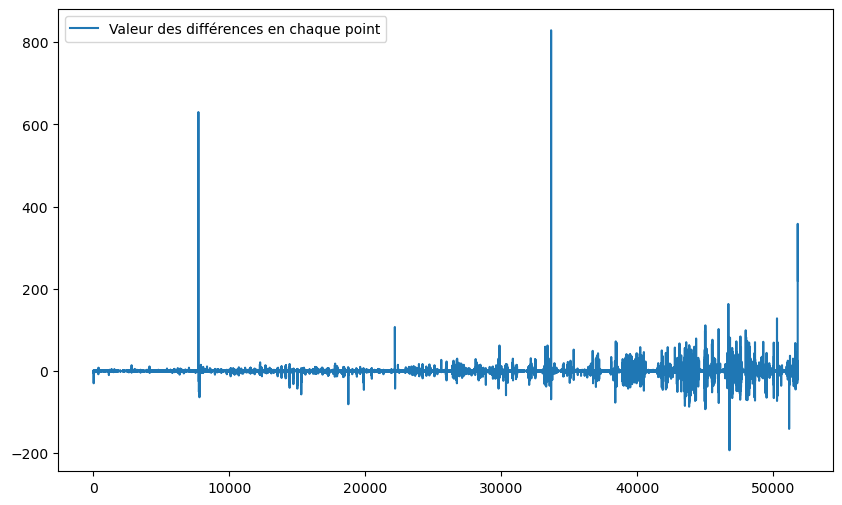

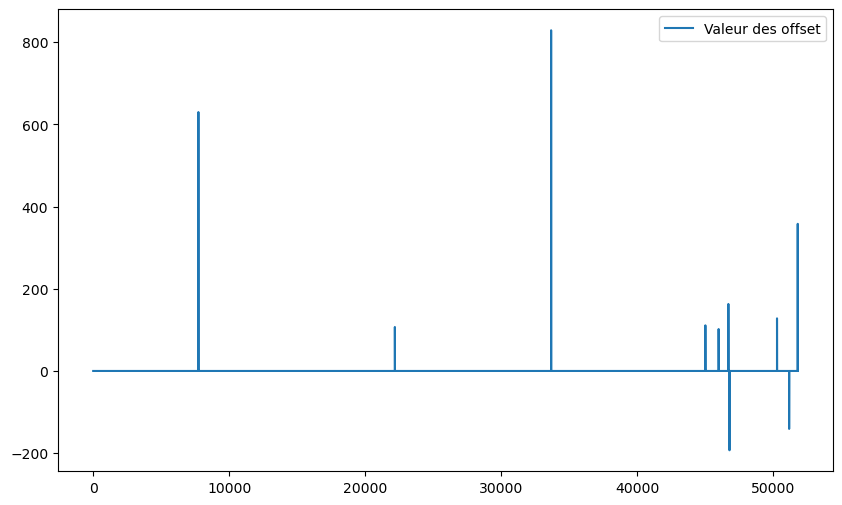

In [11]:
# Valeur des offset
data_diff = []
data_offset = []
k = 0
for i in range(0,len(data_clean)-1):
    data_diff.append(data_clean[i+1]-data_clean[i])
    if i == offset[k] : 
        data_offset.append(data_clean[i]-data_clean[i-1])
        if k < len(offset) -1 :
            k += 1
    else : 
        data_offset.append(0)
    
   
# Transformation en série temporelle
time_serie_diff = pd.Series(data_diff, dtype='float64')
time_serie_offset = pd.Series(data_offset, dtype='float64')

# Affichage de la série diff
plt.figure(figsize=(10, 6))
plt.plot(time_serie_diff, label='Valeur des différences en chaque point')
plt.legend()
plt.show()

# Affichage de la série offset
plt.figure(figsize=(10, 6))
plt.plot(time_serie_offset, label='Valeur des offset')
plt.legend()
plt.show()

### Technique du chat (GPT)

#### Ajustement de l'offset

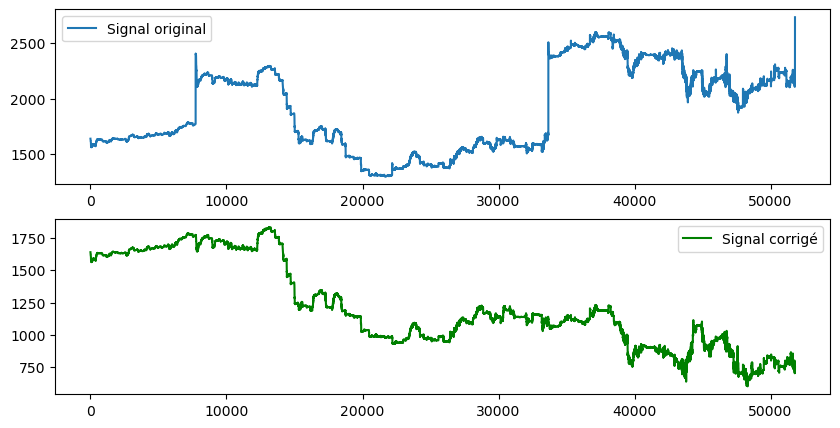

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 50

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

# Correction du signal
data_ajust = data_clean.copy()
for saut in sauts:
    # Ajuster les valeurs après le saut en supprimant l'offset
    offset = data_ajust[saut+1] - data_ajust[saut]
    data_ajust[saut+1:] -= offset

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_ajust, label="Signal corrigé", color='green')
plt.legend()
plt.show()


#### Interpolation

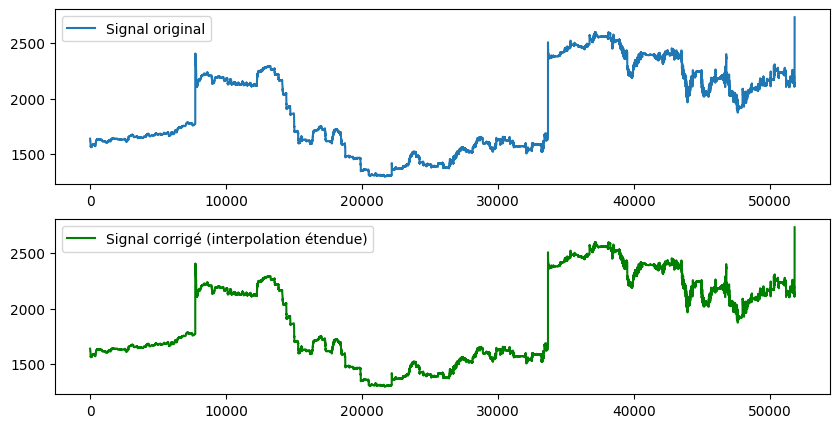

In [49]:
from scipy.interpolate import interp1d

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 50

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

data_interpol = data_clean.copy()

# Nombre de points à utiliser avant et après le saut pour l'interpolation
plage_interpolation = 5  # Ajuster cette valeur selon ton signal

for saut in sauts:
    # Définir les limites de l'intervalle d'interpolation
    start = max(0, saut - plage_interpolation)
    end = min(len(data_clean) - 1, saut + plage_interpolation + 1)
    
    # Points avant et après le saut sur un plus large intervalle
    x_vals = np.arange(start, end)
    y_vals = data_clean[start:end]
    
    # Interpolation linéaire (ou choisir une interpolation cubique, etc.)
    interp = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    
    # Appliquer l'interpolation sur cette portion
    data_interpol[start:end] = interp(np.arange(start, end))

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_interpol, label="Signal corrigé (interpolation étendue)", color='green')
plt.legend()
plt.show()


#### Filtrage (passe-bas)

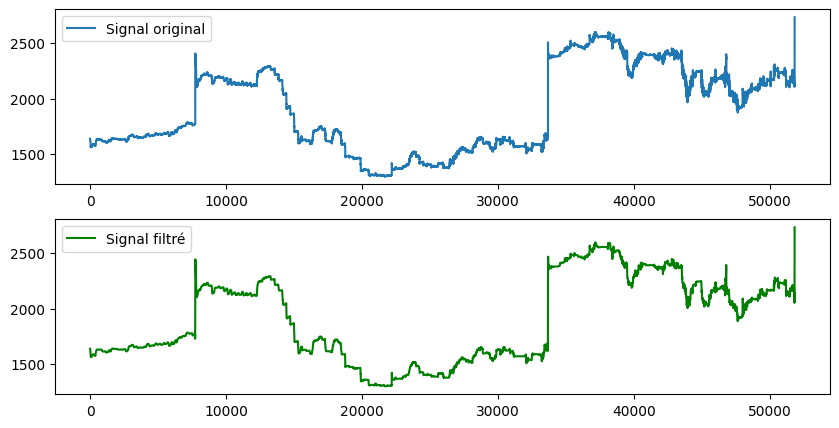

In [50]:
from scipy.signal import butter, filtfilt

# Paramètres du filtre
ordre = 4
frequence_coupure = 0.1 # A ajuster selon ton signal

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_clean)

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.show()

# Décomposition spéctrale

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

Text(0, 0.5, 'Spectre Amplitude')

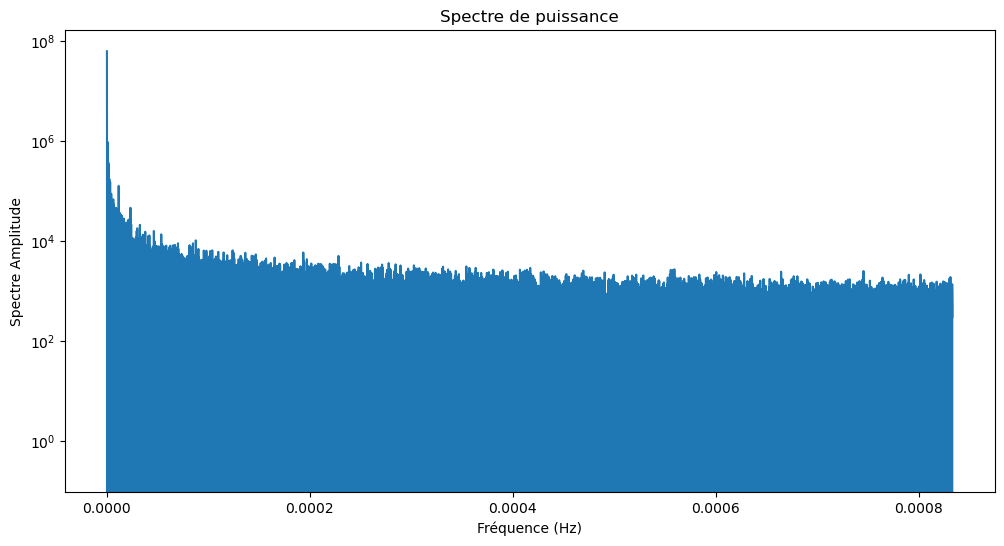

In [13]:
amplitudes = np.real(np.fft.rfft(data_ajust))

frequencies = np.fft.rfftfreq(len(data_ajust),5*60) # 900 = 5*60 : un point tout les 5 min


plt.figure(figsize=(12, 6))

plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2])
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')

Text(0, 0.5, 'Amplitude')

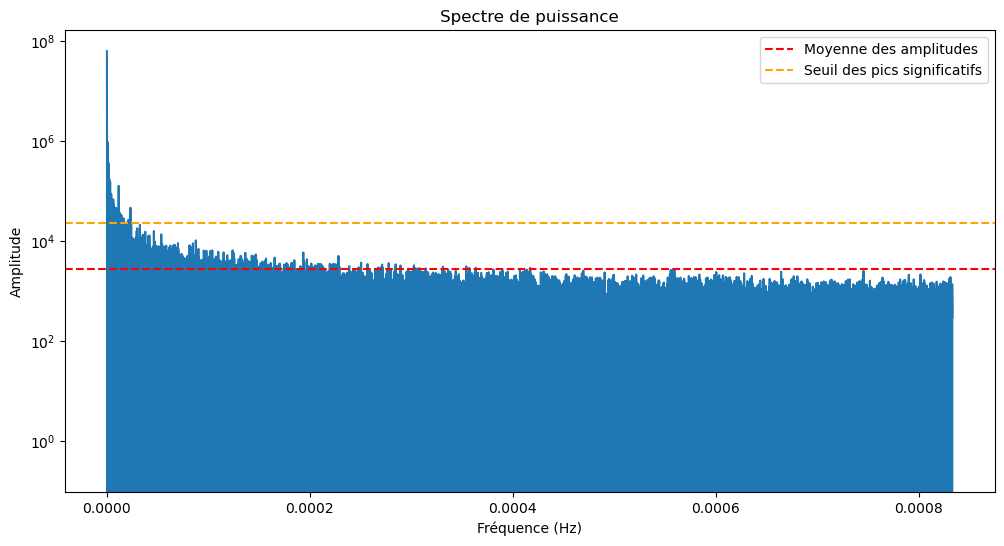

In [14]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points

# Transformée de Fourier du signal
signal_fft = np.fft.rfft(data_ajust) # rfft car signal à valeurs réelles
frequences = np.fft.rfftfreq(N, T) # retourne sous forme de complexes
amplitudes = np.real(signal_fft) # on prend la partie réelle

plt.figure(figsize=(12, 6))

# on affiche que la moitié car pour un signal réel 
# au-delà de la fréquence de Nyquist cela n'apport pas plus d'informations
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2])

# utile pour la suite
plt.axhline(y=np.mean(amplitudes), color='red', linestyle='--',label='Moyenne des amplitudes')
plt.axhline(y=np.mean(amplitudes)*8, color='orange', linestyle='--',label='Seuil des pics significatifs')
plt.legend()

plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

In [15]:
# Détection des pics dans le spectre d'amplitude
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 8)  # Seulement les pics significatifs

# Première fréquence dominante
frequence_principale = frequences[peaks[0]] 
periode_principale = 1 / frequence_principale 
print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 25.74350 1e-8 Hz, soit une période d'environ 44.96 jours


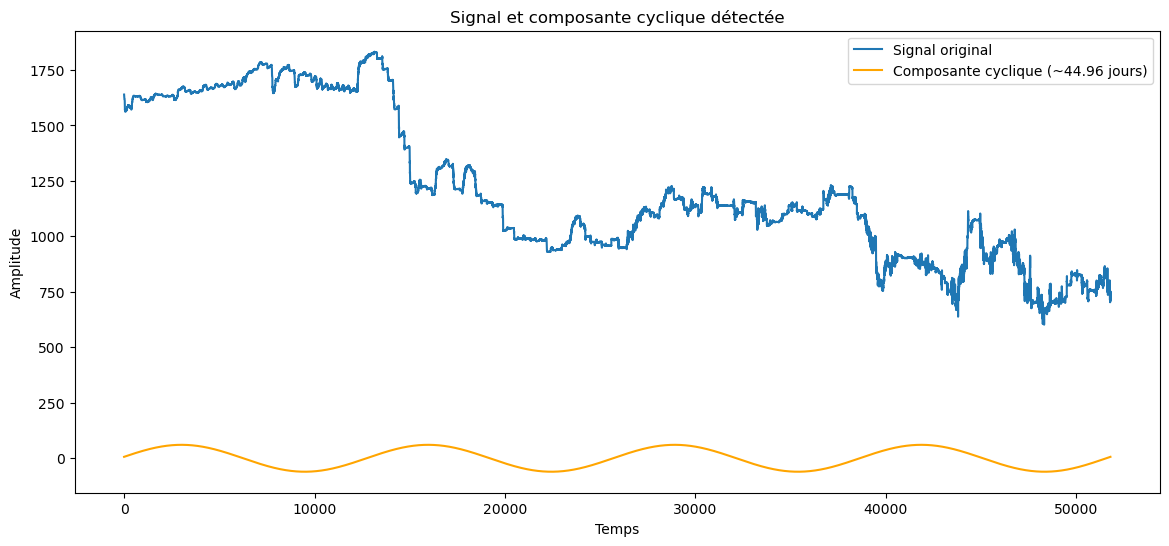

In [16]:
# Filtrage autour de la fréquence dominante
largeur_bande = frequence_principale / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale) < largeur_bande)

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft = signal_fft * filtre_cyclique
signal_cyclique = np.fft.irfft(signal_cyclique_fft)


# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_cyclique.real, label=f"Composante cyclique (~{periode_principale / (3600*24):.2f} jours)", color="orange")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

### Reconstruire le signal avec les fréquences principales

In [17]:
signal_rec = np.zeros(len(data_ajust))
for p in peaks :
    largeur_bande = frequences[p] / 50  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
    filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequences[p]) < largeur_bande)

    # Appliquer le filtre pour isoler la composante cyclique
    signal_cyclique_fft = signal_fft * filtre_cyclique
    signal_cyclique = np.fft.irfft(signal_cyclique_fft)
    signal_rec += signal_cyclique

plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_rec, label="Signal reconstitué ")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (51793,) (51792,) (51793,) 

Les 45 premières fréquences ( trouvées par peaks ) ne sont pas super représentatives

## Densité spectrale

In [18]:
from scipy.signal import welch

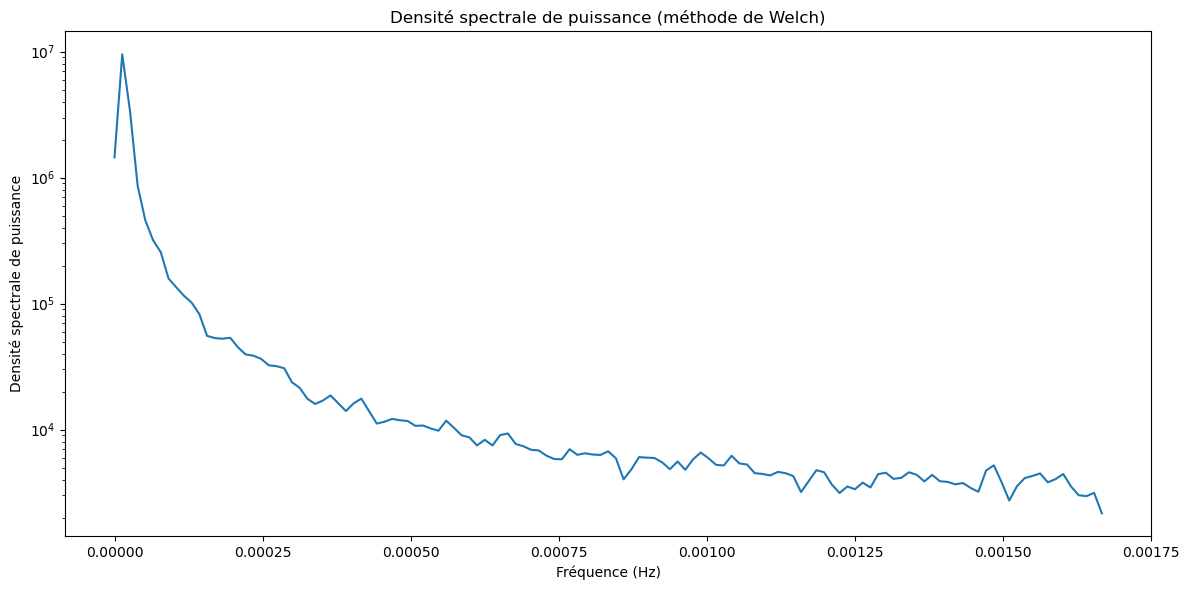

0.8888888888888888
inf


/var/folders/gn/sy_p6gyd0s15vprgs70pb0dr0000gn/T/ipykernel_67633/1694516982.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  print( 1/frequencies[np.argmin(frequencies)] /(3600*24))


In [ ]:
T = 60*5 
fs = 1 / T  

frequencies, power_spectral_density = welch(data_ajust, fs=fs, nperseg = 256 , noverlap = 256/4)

# Tracé du signal d'origine
plt.figure(figsize=(12, 6))

plt.semilogy(frequencies, np.abs(power_spectral_density))
plt.title('Densité spectrale de puissance (méthode de Welch)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')

plt.tight_layout()
plt.show()

print( 1/frequencies[np.argmax(np.abs(power_spectral_density))] /(3600*24))
print(f"La plus basse fréquence principale est : {frequencies[np.argmax(np.abs(power_spectral_density))]} Hz")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.fft import ifft

# Supposons que `signal` soit ton signal et `fs` la fréquence d'échantillonnage
signal = data_ajust  # Remplace avec ton propre signal
T = 60*5 
fs = 1 / T  # Remplace par la fréquence d'échantillonnage réelle du signal

# Décomposition spectrale de Welch
frequencies, power_spectral_density = welch(signal, fs=fs, nperseg=256)

# Identification des fréquences dominantes
peaks, _ = find_peaks(np.abs(power_spectral_density))
dominant_frequencies = frequencies[peaks]
dominant_powers = power_spectral_density[peaks]

# Recherche de la plus basse fréquence dominante
min_freq_index = np.argmin(dominant_frequencies)
min_freq = dominant_frequencies[min_freq_index]

print(f"La plus basse fréquence principale est : {min_freq} Hz")
print(f"Ca correspond à  : {1/min_freq /(3600*24)} jours")

# Reconstruction de la tendance par filtrage
# On construit un signal harmonique avec la fréquence de tendance
t = np.arange(len(signal)) / fs
trend = np.cos(2 * np.pi * min_freq * t)

# Visualisation
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencies, np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(dominant_frequencies, np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(min_freq, color='r', linestyle='--', label=f"Fréquence de tendance ({min_freq:.2f} Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(2, 1, 2)
plt.plot(signal, label="Signal d'origine")
plt.plot(trend, label=f"Tendance reconstruite ({min_freq:.2f} Hz)", linestyle='--')
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Signal et tendance reconstruite")

plt.tight_layout()
plt.show()


# Série temporelle

### Modélisation avec la librairie STL

On a remarqué que les points étaient relevés toutes les 15 mins (pour les 2 premiers mois) après c'est toutes les 5 mins

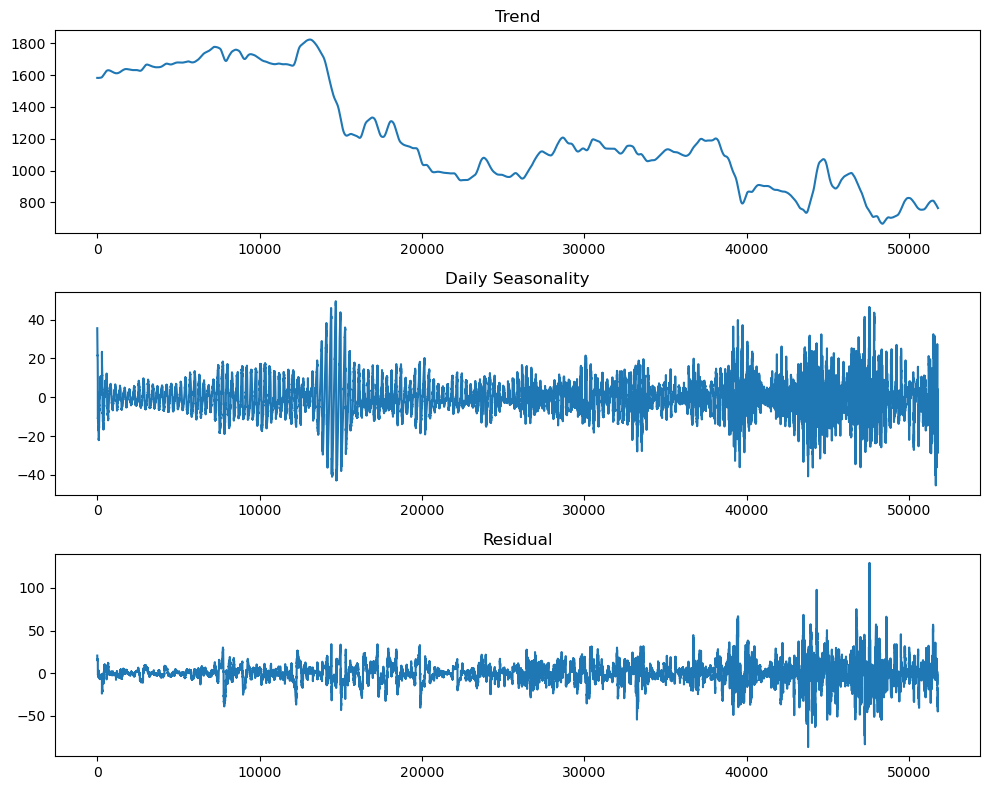

In [20]:

from statsmodels.tsa.seasonal import STL
# Calculate rolling mean (trend approximation)
data = pd.Series(data_ajust)

stl = STL(data, period=24*12)  # Daily seasonality (96 for 15-minute intervals in a day)
result = stl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
ax1.plot(result.trend)
ax1.set_title('Trend')
ax2.plot(result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(result.resid)
ax3.set_title('Residual')
plt.tight_layout()
plt.show()

C'est bien si on a que une seule saisonnalité à identifier mais là y jour / saison ?

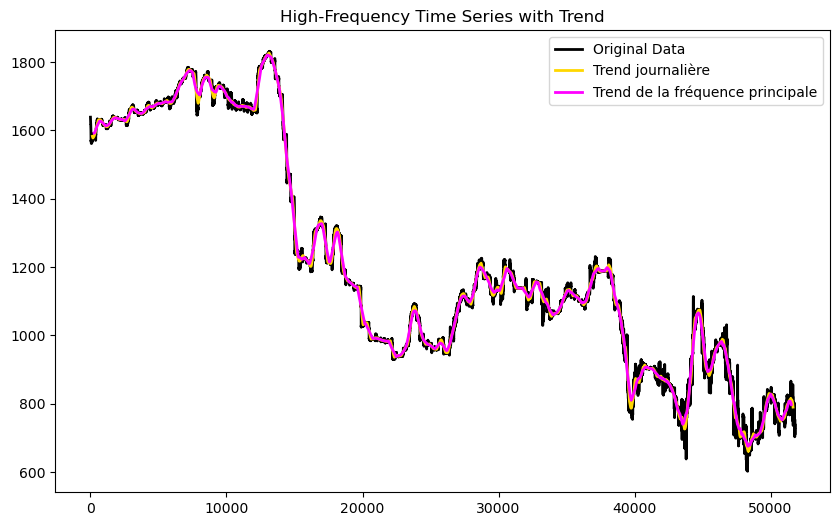

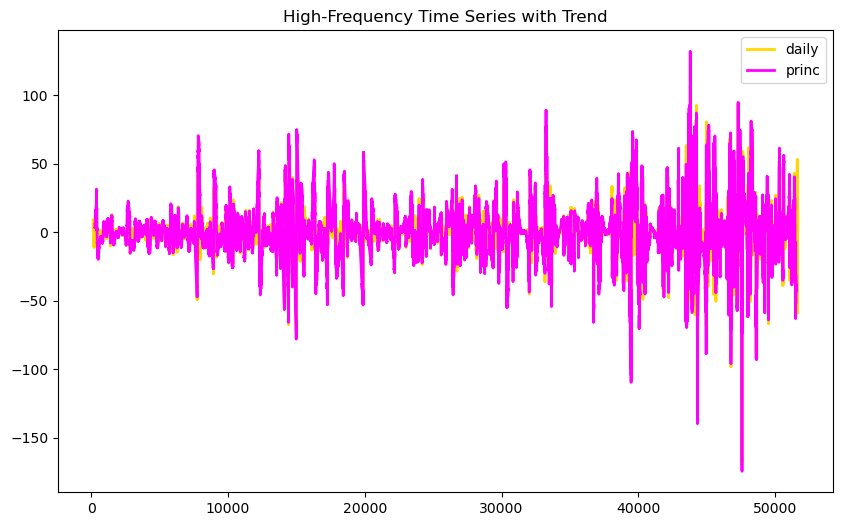

In [21]:
# Calculate rolling mean (adjust window to 96 for daily trends)
rolling_mean_d = data.rolling(window=24*12, center=True).mean()
rolling_mean_p = data.rolling(window=int(12*periode_principale/(3600*24)), center=True).mean()

# Plot the original time series and its trend
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', color='black', linewidth=2)
plt.plot(rolling_mean_d, label='Trend journalière', color='gold', linewidth=2)
plt.plot(rolling_mean_p, label='Trend de la fréquence principale', color='fuchsia', linewidth=2)
plt.legend()
plt.title('High-Frequency Time Series with Trend')
plt.show()

daily = rolling_mean_d-data
princ = rolling_mean_p-data

plt.figure(figsize=(10, 6))
plt.plot(daily, label='daily', color='gold', linewidth=2)
plt.plot(princ, label='princ', color='fuchsia', linewidth=2)
plt.legend()
plt.title('High-Frequency Time Series with Trend')
plt.show()

## On différencie

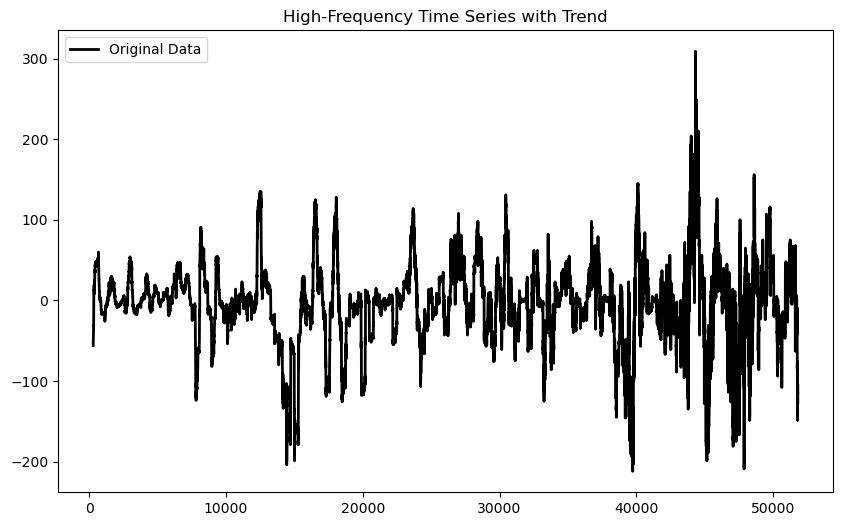

In [22]:
data_diff = pd.Series(data_ajust).diff(periods=300)
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label='Original Data', color='black', linewidth=2)
plt.legend()
plt.title('High-Frequency Time Series with Trend')
plt.show()

### Modélisation à la main

In [ ]:
# Calcul de l'autocorrélation
def autocorrelation(series, max_lag):
    acf = [1.0]  # Autocorrélation au décalage 0 est toujours 1
    mean = np.mean(series)
    var = np.var(series)
    for lag in range(1, max_lag + 1):
        cov = np.sum((series[:-lag] - mean) * (series[lag:] - mean)) / len(series)
        acf.append(cov / var)
    return acf

In [ ]:
# Plot de la tendance à l'aide d'un filtre passe-bas

from scipy.signal import butter, filtfilt

# Paramètres du filtre
ordre = 5
frequence_coupure = 0.001 # A ajuster selon ton signal

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_ajust)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20
acf_values = autocorrelation(residus, max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 5))
plt.stem(range(max_lag + 1), acf_values)
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

In [ ]:
# Plot de la tendance à l'aide de la moyenne mobile

# Calculate rolling mean (adjust window to 96 for daily trends)
rolling_mean_d = data.rolling(window=24*12, center=True).mean()
rolling_mean_p = data.rolling(window=int(12*periode_principale/(3600*24)), center=True).mean()

# Plot the original time series and its trend
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data, label='Original Data', color='black', linewidth=2)
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(rolling_mean_d, label='Trend journalière', color='gold', linewidth=2)
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(rolling_mean_p, label='Trend de la fréquence principale', color='fuchsia', linewidth=2)
plt.legend()
plt.show()

daily = rolling_mean_d-data
princ = rolling_mean_p-data

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(daily, label='daily', color='gold', linewidth=2)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(princ, label='princ', color='fuchsia', linewidth=2)
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20
acf_values_daily = autocorrelation(daily, max_lag)
acf_values_princ = autocorrelation(princ, max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.stem(range(max_lag + 1), acf_values_daily, linefmt="gold")
plt.subplot(2, 1, 2)
plt.stem(range(max_lag + 1), acf_values_princ, linefmt="fuchsia")
plt.show()

# Première modélisation naïve

In [62]:
# # SARIMA parameters
# p, d, q = 1, 1, 1    
# P, D, Q, s = 1, 1, 1, 96  # Seasonality every 96 time steps

# # Building the SARIMA model
# model = SARIMAX(time_serie, order=(p, d, q), seasonal_order=(P, D, Q, s))
# model_fit = model.fit(disp=False)

# # Display the model summary
# print(model_fit.summary())